<div dir="rtl" style="text-align: right;">

# این کد یک ماتریس کوواریانس را با استفاده از **تجزیه چولسکی** و **تجزیه طیفی** تحلیل می‌کند. با این کار، نه تنها **مثبت معین بودن** ماتریس تأیید می‌شود، بلکه ساختار واریانس و همبستگی داده‌ها نیز برای مدل‌سازی‌های آماری بهتر آشکار می‌گردد.

In [1]:
import numpy as np
from scipy import linalg

def covariance_decomposition(covariance_matrix):
    """
    Decomposes the covariance matrix using Cholesky and Spectral decomposition.

    Args:
        covariance_matrix (numpy.ndarray): The covariance matrix.

    Returns:
        tuple: Cholesky decomposition and spectral decomposition results.
    """
    try:
        cholesky_decomposition = linalg.cholesky(covariance_matrix, lower=True)
    except linalg.LinAlgError:
        print("Covariance matrix is not positive definite. Cholesky decomposition failed.")
        cholesky_decomposition = None

    eigenvalues, eigenvectors = linalg.eigh(covariance_matrix)
    spectral_decomposition = (eigenvalues, eigenvectors)

    return cholesky_decomposition, spectral_decomposition

covariance_matrix = np.array([[4, 2], [2, 3]])
cholesky_result, spectral_result = covariance_decomposition(covariance_matrix)

if cholesky_result is not None:
    print("Cholesky Decomposition:")
    print(cholesky_result)

print("\nSpectral Decomposition:")
print("Eigenvalues:")
print(spectral_result[0])
print("Eigenvectors:")
print(spectral_result[1])

if np.all(spectral_result[0] > 0):
    print("\nThe covariance matrix is positive definite.")
else:
    print("\nThe covariance matrix is not positive definite.")

Cholesky Decomposition:
[[2.         0.        ]
 [1.         1.41421356]]

Spectral Decomposition:
Eigenvalues:
[1.43844719 5.56155281]
Eigenvectors:
[[ 0.61541221 -0.78820544]
 [-0.78820544 -0.61541221]]

The covariance matrix is positive definite.


<div dir="rtl" style="text-align: right;">


# این کد با استفاده از داده‌های زنبق، یک **مدل گرافیکی گاوسی** می‌سازد و روابط وابستگی شرطی بین ویژگی‌ها را نمایش می‌دهد. این فرآیند شامل محاسبه ماتریس دقت و انجام **آزمون معناداری t** برای تعیین وجود یال‌های معنی‌دار است.

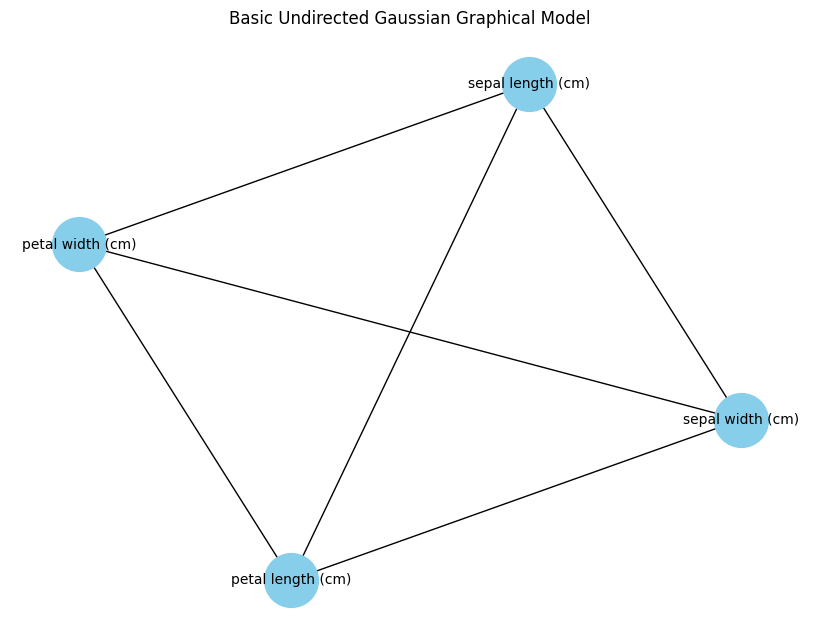

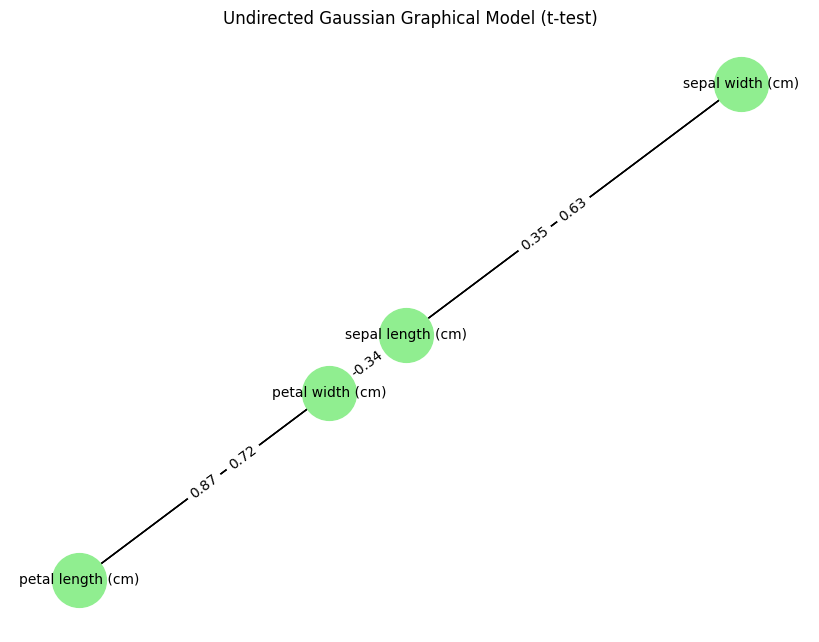

Partial Correlation Matrix:
[[ 0.     0.629  0.719 -0.34 ]
 [ 0.629  0.    -0.615  0.353]
 [ 0.719 -0.615  0.     0.871]
 [-0.34   0.353  0.871  0.   ]]


In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy import linalg
from scipy.stats import t

def build_ggm_from_precision(precision_matrix, feature_names):
    """
    Builds an undirected Gaussian Graphical Model from a precision matrix.
    Edges are drawn between features with non-zero partial correlation.
    """
    graph = nx.Graph()
    num_vars = precision_matrix.shape[0]
    for i in range(num_vars):
        graph.add_node(feature_names[i])
        for j in range(i + 1, num_vars):
            # Check for non-zero precision entry to infer an edge
            # A small tolerance is used due to floating-point arithmetic
            if not np.isclose(precision_matrix[i, j], 0):
                graph.add_edge(feature_names[i], feature_names[j])
    return graph

def calculate_partial_corr(precision_matrix):
    """
    Calculates the partial correlation matrix from the precision matrix.
    """
    num_vars = precision_matrix.shape[0]
    partial_corr_matrix = np.zeros_like(precision_matrix)
    for i in range(num_vars):
        for j in range(num_vars):
            if i != j:
                # Formula for partial correlation from precision matrix
                partial_corr_matrix[i, j] = -precision_matrix[i, j] / np.sqrt(precision_matrix[i, i] * precision_matrix[j, j])
    return partial_corr_matrix

def build_ggm_with_t_test(data, feature_names, alpha=0.05):
    """
    Builds an undirected Gaussian Graphical Model using a t-test for partial correlations.
    Edges are drawn only if the partial correlation is statistically significant.
    """
    covariance_matrix = np.cov(data.T)
    precision_matrix = linalg.inv(covariance_matrix)
    partial_corr_matrix = calculate_partial_corr(precision_matrix)

    n = data.shape[0]
    num_vars = data.shape[1]
    df = n - num_vars

    graph = nx.Graph()
    for i in range(num_vars):
        graph.add_node(feature_names[i])
        for j in range(i + 1, num_vars):
            # The t-statistic for partial correlation
            t_stat = (partial_corr_matrix[i, j] * np.sqrt(df)) / np.sqrt(1 - partial_corr_matrix[i, j]**2)
            # Two-tailed p-value
            p_value = 2 * (1 - t.cdf(abs(t_stat), df))

            if p_value < alpha:
                graph.add_edge(feature_names[i], feature_names[j], weight=partial_corr_matrix[i,j])

    return graph

# 1. Load data
iris = datasets.load_iris()
X = iris.data
feature_names = iris.feature_names

# 2. Build and visualize the basic GGM (based on non-zero entries)
covariance_matrix = np.cov(X.T)
precision_matrix = linalg.inv(covariance_matrix)
ggm_basic = build_ggm_from_precision(precision_matrix, feature_names)

plt.figure(figsize=(8, 6))
pos_basic = nx.spring_layout(ggm_basic, seed=42)
nx.draw(ggm_basic, pos_basic, with_labels=True, node_size=1500, node_color='skyblue', font_size=10)
plt.title("Basic Undirected Gaussian Graphical Model")
plt.show()

# 3. Build and visualize the GGM with t-test for statistical significance
ggm_t_test = build_ggm_with_t_test(X, feature_names)

plt.figure(figsize=(8, 6))
pos_t_test = nx.spring_layout(ggm_t_test, seed=42)
nx.draw(ggm_t_test, pos_t_test, with_labels=True, node_size=1500, node_color='lightgreen', font_size=10)
edge_labels = nx.get_edge_attributes(ggm_t_test, 'weight')
nx.draw_networkx_edge_labels(ggm_t_test, pos_t_test, edge_labels={k: f'{v:.2f}' for k, v in edge_labels.items()})
plt.title("Undirected Gaussian Graphical Model (t-test)")
plt.show()

# 4. Print the partial correlation matrix for reference
partial_corr_matrix = calculate_partial_corr(precision_matrix)
print("Partial Correlation Matrix:")
print(np.round(partial_corr_matrix, 3))